In [1]:
import os
import h5py
import copy
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize
from sklearn.metrics import r2_score

import cobra
import snek

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms

In [2]:
d4p3 = cobra.io.read_sbml_model("../models/ecoli_core_btdl_pathway.xml")

In [3]:
def get_plot_kwargs(run):
    kwargs = {}
    
    if "paper" in run:
        kwargs["color"] = "lightblue"
        print(run)
        if "3C" in run:
            kwargs["marker"] = "X"
        else:
            kwargs["marker"] ="P"
    elif "control" in run:
        kwargs["color"] = "#1737ab"
        if "A" in run:
            kwargs["marker"] = "X"
        else:
            kwargs["marker"] = "P"
    else:
        kwargs["color"] = "#acd429"
        if "A" in run:
            kwargs["marker"] = "X"
        else:
            kwargs["marker"] = "P"
    kwargs["edgecolor"] = "k"
    kwargs["zorder"] = -1
    kwargs["s"] = 30
    kwargs["linewidths"] =.5
    return kwargs

# glucose concentration in "feed"
c_G = 800/0.18015588 # mmol/L

# matplotlib params
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath}\sansmath'

In [4]:
def get_run(xls,run):
    tmp = xls[xls.Runs==run].copy()
    if "paper" in run:
        factor = 1
    else:
        factor = 1
    tmp.V = tmp.V.values * factor
    tmp.insert(0,"X",tmp.x*tmp.V/1000)
    tmp.insert(0,"B",tmp.b*tmp.V/1000)
    tmp.insert(0,"A",tmp.a*tmp.V/1000)
    tmp.insert(0,"G",tmp.g*tmp.V/1000)
    
    tmpG = tmp.G.values
    old = 0
    adder = np.zeros(len(tmpG))
    for i in range(len(tmpG)):
        new = tmpG[::-1][i]
        if new >= old:
            old = new
        else:
            adder[:-i] += old-new
            # print(old-new)
            old = new
    Gfed = adder+tmpG

    tmp.insert(0,"Gfed",Gfed)
    tmp.insert(0,"Gup",Gfed[0]-Gfed)
    
    return tmp

def parse_summary_file2(full_path):
    # get summary
    with open(full_path,"r") as file:
        lines = file.readlines()

    timing = False
    sum_dic = {}
    for i, line in enumerate(lines):
        if (i)%3 == 0:
            pass
        elif (i-2)%3 == 0:
            if line[0].isnumeric() or line[0] == "-":
                tmp_item = [float(line)]
            else:
                tmp_str = line.strip("\n")
                if tmp_str[0] == "[":
                    tmp_item = [[float(i) for i in tmp_str.strip("[").strip("]").split(",")]]
                else:
                    tmp_item = [tmp_str]
                pass
            if timing:
                sum_dic[tmp_key+" in s"] = tmp_item
                sum_dic[tmp_key+" in min"] = [i/60 for i in tmp_item]
            else:
                sum_dic[tmp_key.replace("pDNA","product")] = tmp_item
        else:
            tmp_key = line.strip("#----").strip("\n")
            if "Time E" in tmp_key:
                timing = True
            else:
                timing = False
    sum_df = pd.DataFrame(sum_dic).T
    sum_df.columns = [full_path]
    return sum_dic, sum_df

xls = pd.read_excel("~/julia/240112_boku/analysis/original_data/240809_combined_experimental_data.xlsx")

xls = xls.rename(columns={
    "time [h]":"t",
    "V reactor [ml]":"V",
    "CDM [g/l]":"x",
    "glucose [g/l]":"g",
    "meso-2,3-BDO [g/l]":"b",
    "acetoin [g/l]":"a"
})

runs = xls.Runs.unique()

def printer(text,top=False,bottom=False):
    if top:
        print("-"*len(text))
    print(text)
    if bottom:
        print("-"*len(text))

In [5]:
# this is the mean X0 from the Erian et al. Paper Processes
theoretical_X0 = (0.758333333333342 + 0.666666666666593)/2
tnorm_dict = {}
tswitch_dict = {}
tend_dict = {}

for run in runs:
    tmp = get_run(xls,run)
    # check witch parts of the run are aerbic/ microaerobic/ and not nan
    aerobic = tmp.Stage =="aerobic"
    micro = tmp.Stage == "microaerobic"
    notnan = np.isfinite(tmp.X)
    # parse t_switch (first time point of microaerobic)
    t_switch = tmp.t[micro].values[0]
    # parse closes values of X
    xxA = tmp.X[aerobic&notnan].values/tmp.V.values[0]*1000
    ttA = tmp.t[aerobic&notnan].values
    xxM = tmp.X[micro&notnan].values/tmp.V.values[0]*1000
    ttM = tmp.t[micro&notnan].values
    x_switch = (xxA[-1]*(ttM[0]-t_switch)+xxM[0]*(t_switch-ttA[-1]))/((ttM[0]-ttA[-1]))
    # print(xxA[0])
    
    GR_qX = 0.1894
    tnorm = np.log(x_switch/theoretical_X0)/GR_qX
    tls = np.linspace(0,tnorm,100)
    exp = theoretical_X0*np.exp(GR_qX*tls)
    
    tnorm_dict[run] = tnorm
    tswitch_dict[run] = t_switch
    tend_dict[run] = tmp.t.values[-1]-t_switch+tnorm

# SUPPLEMENTARY FIGURE S2

paper_3C
paper_S3


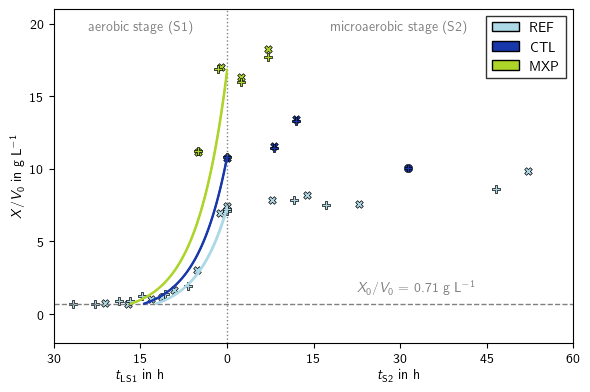

In [6]:
# this is the mean X0 from the Erian et al. Paper Processes
theoretical_X0 = (0.758333333333342 + 0.666666666666593)/2
tnorm_dict = {}
tswitch_dict = {}
tend_dict = {}
colors = ["#c39e08","#84993a","#57a585","#77a5b8","#1c6791","#102f73","#091c47"]

f = 1
plt.figure(dpi=100,figsize=(6*f,4*f))

for run in runs:
    tmp = get_run(xls,run)
    # check witch parts of the run are aerbic/ microaerobic/ and not nan
    aerobic = tmp.Stage =="aerobic"
    micro = tmp.Stage == "microaerobic"
    notnan = np.isfinite(tmp.X)
    # parse t_switch (first time point of microaerobic)
    t_switch = tmp.t[micro].values[0]
    # parse closes values of X
    xxA = tmp.X[aerobic&notnan].values/tmp.V.values[0]*1000
    ttA = tmp.t[aerobic&notnan].values
    xxM = tmp.X[micro&notnan].values/tmp.V.values[0]*1000
    ttM = tmp.t[micro&notnan].values
    x_switch = (xxA[-1]*(ttM[0]-t_switch)+xxM[0]*(t_switch-ttA[-1]))/((ttM[0]-ttA[-1]))
    GR_qX = 0.1894
    tnorm = np.log(x_switch/theoretical_X0)/GR_qX
    tls = np.linspace(0,tnorm,100)
    exp = theoretical_X0*np.exp(GR_qX*tls)
    
    tnorm_dict[run] = tnorm
    tswitch_dict[run] = t_switch
    tend_dict[run] = tmp.t.values[-1]-t_switch+tnorm
    
    kwargs = get_plot_kwargs(run)
    
    if "paper" in run:
        if "3C" in run:
            lab = "REF"
        else:
            lab = None
    elif "control" in run:
        if "A" in run:
            lab = "CTL"
        else:
            lab = None
    else:
        if "A" in run:
            lab = r"MXP"
        else:
            lab = None
        
    plt.plot(tls-tnorm,exp,zorder=10,color=kwargs["color"])#,label=f"tnorm = {tnorm:.2f} h")
    plt.scatter(tmp.t[notnan]-t_switch,tmp.X[notnan]/tmp.V.values[0]*1000,**kwargs)
    plt.bar(-100,0,color=kwargs["color"],label=lab,edgecolor="k")
    
plt.axvline(0,color="grey",zorder=-1,linewidth=1,linestyle=":")
plt.axhline(theoretical_X0,color="grey",zorder=-1,linewidth=1,linestyle="--")
plt.ylim(-2,21)
plt.xlim(-30,60)
a = np.linspace(-30,60,7)
plt.xticks(a,np.abs(a).astype(int))
plt.ylabel(r"$X/V_0$ in g\;L$^{-1}$")
plt.legend(loc="upper right")
plt.text(-15,-4.5,r"$t_{\rm LS1}$ in h",ha="center")
plt.text( 30,-4.5,r"$t_{\rm S2}$ in h",ha="center")
plt.text(-15,19.5," aerobic stage (S1)",ha="center",color="grey")
plt.text( 30,19.5,"microaerobic stage (S2)",ha="center",color="grey")
plt.text(45/2,1.5,r"$X_0/V_0$ ="+f" {theoretical_X0:.2f} "+r"g\;L$^{-1}$",color="grey")


plt.tight_layout()
plt.show()

In [7]:
def parse_summary_file2(full_path):
    # get summary
    with open(full_path,"r") as file:
        lines = file.readlines()

    timing = False
    sum_dic = {}
    for i, line in enumerate(lines):
        if (i)%3 == 0:
            pass
        elif (i-2)%3 == 0:
            if line[0].isnumeric() or line[0] == "-":
                tmp_item = [float(line)]
            else:
                tmp_str = line.strip("\n")
                if tmp_str[0] == "[":
                    tmp_item = [[float(i) for i in tmp_str.strip("[").strip("]").split(",")]]
                else:
                    tmp_item = [tmp_str]
                pass
            if timing:
                sum_dic[tmp_key+" in s"] = tmp_item
                sum_dic[tmp_key+" in min"] = [i/60 for i in tmp_item]
            else:
                sum_dic[tmp_key.replace("pDNA","product")] = tmp_item
        else:
            tmp_key = line.strip("#----").strip("\n")
            if "Time E" in tmp_key:
                timing = True
            else:
                timing = False
    sum_df = pd.DataFrame(sum_dic).T
    sum_df.columns = [full_path]
    return sum_dic, sum_df

def get_lists(folder,verbose=True):
    PVs = []
    Pts = []
    tends = []
    qOmaxs = []
    return_PVs = []
    valid_names = []
    names = []
    tS1s = []
    NF_counter = 0
    for i in os.walk(folder):
        for name in i[2]:
            if ".jl" in name and not "template" in name and not "xx" in name and not "yy" in name:
                valid_names.append(name)
        for name in sorted(valid_names,key=lambda x: float(x[:-3])):
            with open(folder+"/"+name,"r") as file:
                lines = file.readlines()
            indicatorA = 0
            for line in lines:
                if "NLobjective" in line:
                    indicatorA = 1
                if indicatorA and "N[4,end,end]/V[end,end]" in line:
                    return_PV = True
                    break
                elif indicatorA and "N[4,end,end]/t_end" in line:
                    return_PV = False
                    break
            else:
                print("UNIDENTIFIED OBJECTIVE")
            for line in lines:
                if "t_max = " in line:
                    tmp_tend = float(line.split()[2])
                if "vlb[xxx] = " in line:
                    qXmin = float(line.split()[2])

            file_dir = folder+"/"+name[:-3]+"/df.csv"
            if os.path.isfile(file_dir):
                df = pd.read_csv(file_dir)

                sum_dic, sum_df = parse_summary_file2(folder+"/"+name[:-3]+"/summary.txt")
                tstat = sum_dic["Termination Status"][0]
                print_name = name
                if "SOLVED" in sum_dic["Termination Status"][0]:
                    tmp_P = df.P.values[-1]
                    tmp_Pt = df.P.values[-1]/df.t.values[-1]/df.V.values[-1]/1000*d4p3.metabolites.bt23dl_c.formula_weight
                    tmp_PV = df.P.values[-1]/df.V.values[-1]/1000*d4p3.metabolites.bt23dl_c.formula_weight
                    tmp_PG = df.P.values[-1]/((df.V.values[-1]-df.V.values[0])*c_G)
                    tmp_PgGg = tmp_PG*d4p3.metabolites.bt23dl_c.formula_weight/d4p3.metabolites.glc__D_e.formula_weight
                    # length of the initial stage
                    ss = np.invert(np.isclose(df.q_X.values[1:],df.q_X.values[1],rtol=1e-2,atol=1e-2))
                    if np.any(ss):
                        tmp_tS1 = df.t.values[1:][ss][0]
                    else:
                        tmp_tS1 = np.nan
                else:
                    if "LOCALLY_INFEASIBLE" in sum_dic["Termination Status"][0]:
                        pass
                    else:
                        pass
                    tmp_P  = np.nan
                    tmp_Pt = np.nan
                    tmp_PV = np.nan
                    tmp_PG = np.nan
                    tmp_PgGg = np.nan
                    tmp_tS1 = np.nan
                    
            else:
                tmp_P  = np.nan
                tmp_Pt = np.nan
                tmp_PV = np.nan
                tmp_PG = np.nan
                tmp_PgGg = np.nan
                tmp_tS1 = np.nan
                tstat = ""
                
                print_name = name + " NF"
                NF_counter += 1
            qOmax = qXmin
            if verbose:
                print(f"""{print_name:20} | {tstat[:20]:20} | {tmp_P:>7.2f} | {tmp_Pt:7.2f} | {tmp_PV:7.2f} | {tmp_PG:7.2f} | {tmp_PgGg:7.2f} | {tmp_tend:7.2f} | {qXmin:7.2f}""")

            PVs.append(tmp_PV)
            tends.append(tmp_tend)
            qOmaxs.append(qOmax)
            Pts.append(tmp_Pt)
            return_PVs.append(return_PV)
            names.append(name[:-3])
            tS1s.append(tmp_tS1)
                    
        break
    if verbose:
        print(f"not found: {NF_counter} ({NF_counter/len(valid_names)*100:.0f} %)",)
    return PVs, Pts, tends, qOmaxs, return_PVs, names, tS1s

def calculate_y(X, Y, x):
    x1, x2 = X
    y1, y2 = Y
    
    # Calculate the slope (m)
    m = (y2 - y1) / (x2 - x1)
    
    # Calculate the y-intercept (c)
    c = y1 - m * x1
    
    # Calculate the y value for the given x
    y = m * x + c
    
    return y

def calculate_angle(x1, y1, x2, y2, mx = 0, my = 0):
    """
    Calculate the angle of the line connecting points A and B with respect to the positive x-axis.
    
    Parameters:
    A (tuple): Coordinates of the first point (x1, y1).
    B (tuple): Coordinates of the second point (x2, y2).
    
    Returns:
    float: Angle in degrees.
    """
    # x1, y1 = A
    # x2, y2 = B
    
    # Calculate the difference in coordinates
    dx = (x2 - x1)/mx
    dy = (y2 - y1)/my
    
    # Calculate the angle in radians
    angle_rad = math.atan2(dy, dx)
    
    # Convert angle to degrees
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg


colors = ["#53362e","#744940","#9f7064","#c99582","#e6bcac","#e2d8d6","#a5a6ae","#858794","#666879","#515260","#3d3d47"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

colors = ["#ffea97","#ffc579","#ff9e5e","#ff693d","#f72923","#db0024","#a31333","#6f203d","#441b2a",] # EXETER "#1a1516"
cmapXX = LinearSegmentedColormap.from_list("mycmap", colors)

In [8]:
if 1:
    simshape = 11
    solution_space_nr = '200'
    sims = [solution_space_nr]
    base_path = "../simulations/"
    experimental_simulations = ["fb_ctl"]
    experimental_simulations_labels = ["Control"]
    experimental_simulations_colors = ["#007891"]
    
for nr in sims:
    header1 = f"{'Process':20} | {'Status':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'P/Gfed':7} | {'T_end':7} | {'qX_min':7}"
    header2 = f"{' ':20} | {'':20} | {'mmol':7} | {'mmol/h':7} | {'mmol/L':7} | {'mol/mol':7} | {'g/g':7} | {'h':7} | {'1/h':7}"
    printer(header1,top=1)
    printer(header2,bottom=1)

    folder = f"{base_path}solution_space_{solution_space_nr}"
    PVs, Pts, tends, qOmaxes, return_PVs, valid_names, tS1s = get_lists(folder)
    
    qOmaxes = np.array(qOmaxes)#.reshape(-1,6)
    PVs     = np.array(PVs)#.reshape(-1,6)
    Pts     = np.array(Pts)#.reshape(-1,6)
    tends   = np.array(tends)#.reshape(-1,6)
    return_PVs = np.array(return_PVs)#.reshape(-1,6)
    valid_names = np.array(valid_names)
    tS1s = np.array(tS1s)
    PV_qOmaxes = qOmaxes[return_PVs].reshape(-1,simshape)
    PV_PVs = PVs[return_PVs].reshape(-1,simshape)
    PV_Pts = Pts[return_PVs].reshape(-1,simshape)
    PV_tends = tends[return_PVs].reshape(-1,simshape)
    PV_names = valid_names[return_PVs].reshape(-1,simshape)
    PV_tS1s = tS1s[return_PVs].reshape(-1,simshape)

    Pt_qOmaxes = qOmaxes[np.invert(return_PVs)].reshape(-1,simshape)
    Pt_Pts = Pts[np.invert(return_PVs)].reshape(-1,simshape)
    Pt_PVs = PVs[np.invert(return_PVs)].reshape(-1,simshape)
    Pt_tends = tends[np.invert(return_PVs)].reshape(-1,simshape)
    Pt_names = valid_names[np.invert(return_PVs)].reshape(-1,simshape)
    Pt_tS1s = tS1s[np.invert(return_PVs)].reshape(-1,simshape)

    assert np.all(np.isclose(np.nan_to_num(Pt_tends),np.nan_to_num(PV_tends)))
    assert np.all(np.isclose(np.nan_to_num(Pt_qOmaxes),np.nan_to_num(PV_qOmaxes),atol=1e-3))

-----------------------------------------------------------------------------------------------------------------
Process              | Status               | P       | P/t     | P/V     | P/Gfed  | P/Gfed  | T_end   | qX_min 
                     |                      | mmol    | mmol/h  | mmol/L  | mol/mol | g/g     | h       | 1/h    
-----------------------------------------------------------------------------------------------------------------
001.jl               | LOCALLY_SOLVED       |   55.10 |    0.64 |    6.41 |    0.51 |    0.25 |   10.00 |    0.01
002.jl               | ALMOST_LOCALLY_SOLVE |   54.89 |    0.64 |    6.39 |    0.51 |    0.25 |   10.00 |    0.02
003.jl               | ALMOST_LOCALLY_SOLVE |   54.46 |    0.63 |    6.34 |    0.51 |    0.25 |   10.00 |    0.04
004.jl               | LOCALLY_SOLVED       |   53.86 |    0.63 |    6.27 |    0.51 |    0.25 |   10.00 |    0.06
005.jl               | ALMOST_LOCALLY_SOLVE |   53.02 |    0.62 |    6.18 |    0.51 |   

# SUPPLEMENTARY FIGURE S6

Process              | P       | P/Vt    | P/V     | P/Gfed  | P/Gfed  | Time    | t_S1   
                     | g       | g/(Lh)  | g/L     | mol/mol | g/g     | h       | h      
------------------------------------------------------------------------------------------
MXP                  |   60.76 |    1.81 |   60.76 |    0.61 |    0.30 |   33.52 |   17.00
opt. $\mathcal{P}$   |   50.81 |    2.36 |   50.81 |    0.51 |    0.25 |   21.58 |   19.36
CTL/ REF             |   68.56 |    1.00 |   68.56 |    0.69 |    0.34 |   68.63 |   12.73
opt. $\mathcal{T}$   |   68.37 |    1.02 |   68.37 |    0.68 |    0.34 |   67.00 |   11.14


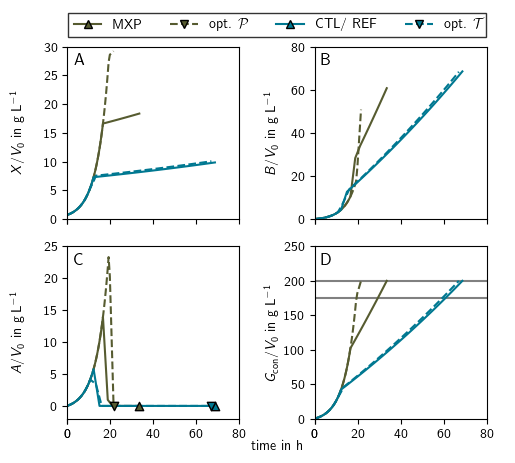

In [9]:
dirnames   = ["fb_mxp","fb_optP","fb_ctl","529"]
dirlabels  = [r"MXP",r"opt. $\mathcal{P}$",r"CTL/ REF",r"opt. $\mathcal{T}$"]
colors     = ["#565b30","#565b30","#007891","#007891"]
linestyles = ["-","--"]*2
markers    = ["^","v"]*2
solution_space_nr = '200'

fig = plt.figure(dpi=100,figsize=(5.5,5))
axes = []
ctrl_t_offset = 4
for i in range(4):
    ax = fig.add_subplot(2,2,i+1,box_aspect=1)
    axes.append(ax)
    ax.set_xlim(0,80)
    ax.set_xticks([0,0,20,40,60,80])
for ax in axes[:2]:
    ax.set_xticklabels([])

# Plot Simulations
if True:
    print(f"{'Process':20} | {'P':7} | {'P/Vt':7} | {'P/V':7} | {'P/Gfed':7} | {'P/Gfed':7} | {'Time':7} | {'t_S1':7}")
    info = f"{' ':20} | {'g':7} | {'g/(Lh)':7} | {'g/L':7} | {'mol/mol':7} | {'g/g':7} | {'h':7} | {'h':7}"
    printer(info,bottom=1)
    for nr, (dirname,label) in enumerate(zip(dirnames,dirlabels)):
        if "fb" in dirname:
            df = pd.read_csv("../simulations/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
            zorder = 1
        else:
            df = pd.read_csv(f"../simulations/solution_space_{solution_space_nr}/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2(f"../simulations/solution_space_{solution_space_nr}/"+dirname+"/summary.txt")
            zorder = 1
        
        kwargs = {"color":colors[nr],"zorder":zorder,"linestyle":linestyles[nr]}
        if True:
            axes[2].plot(df.t,df.S*d4p3.metabolites.acoin_c.formula_weight/1000,**kwargs)
            axes[2].scatter(df.t.values[-1],df.S.values[-1]*d4p3.metabolites.acoin_c.formula_weight/1000,color=colors[nr],edgecolor="k",marker=markers[nr],zorder=2)
            axes[2].plot(-10,-10,label=label,**kwargs,markeredgecolor="k",marker=markers[nr])
            axes[0].plot(df.t,df.X,**kwargs)
            axes[3].plot(df.t,(df.V.values-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000,**kwargs)
            # print(dirname,df.V.values[-1]-df.V.values[0])
            axes[1].plot(df.t,df.P*d4p3.metabolites.bt23dl_c.formula_weight/1000,**kwargs)
        # print process parameters
        if True:
            # print(df.V.values[-1],((df.V.values-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000)[-1])
            tmp_P = df.P.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
            tmp_Pt = df.P.values[-1]/df.V.values[-1]/df.t.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
            tmp_PV = df.P.values[-1]/df.V.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
            tmp_PG = df.P.values[-1]/((df.V.values[-1]-df.V.values[0])*c_G)
            tmp_PgGg = tmp_PG*d4p3.metabolites.bt23dl_c.formula_weight/d4p3.metabolites.glc__D_e.formula_weight
            tS1 = df.t.values[1:][np.invert(np.isclose(df.q_X.values[1:],df.q_X.values[1],atol=1e-2))][0]
            print(f"""{label:20} | {tmp_P:>7.2f} | {tmp_Pt:7.2f} | {tmp_PV:7.2f} | {tmp_PG:7.2f} | {tmp_PgGg:7.2f} | {df.t.values[-1]:7.2f} | {tS1:7.2f}""")
#            print(f"{label:20}"+" ($\\tsI = \\qty{"+f"{tS1:.1f}"+"}{\\hour}$, $\\mathcal{P} = "+"\\qty{"+f"{tmp_Pt:7.1f}"+"}{\\gram\\per\\liter\\per\\hour}$)")
        
# Axes Labels
if True:
    axes[2].set_ylabel(r"$A/V_0$ in g\;L$^{-1}$")
    axes[0].set_ylabel(r"$X/V_0$ in g\;L$^{-1}$")
    axes[3].set_ylabel(r"$G_{\rm con}/V_0$ in g\;L$^{-1}$")
    axes[1].set_ylabel(r"$B/V_0$ in g\;L$^{-1}$")
    axes[2].set_ylim(-2,25)
    axes[0].set_ylim(0,30)
    axes[3].set_ylim(0,250)
    axes[1].set_ylim(0,80)
    axes[0].set_title("\n")
    axes[3].axhline(200,zorder=-5,color="grey",linestyle="-")
    axes[3].axhline(175,zorder=-5,color="grey",linestyle="-")

    # Create invisible subplot.
    ax0 = fig.add_subplot(111, frame_on=False)
    ax0.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    ax0.grid(False)
    # Set the centered xlabel on invisible subplot.
    ax0.set_xlabel("time in h", labelpad=0)
    
# Legend
if True:
    fig.align_ylabels()
    fig.tight_layout()
    ax1_pos = axes[0].get_position()
    ax2_pos = axes[1].get_position()
    legend_x = (ax1_pos.x0 + ax2_pos.x1) / 2
    fig.legend(loc='center', bbox_to_anchor=(legend_x, .93), ncol=4)
    fig.tight_layout()
    
# Panel Legends
if True:
    for name, ax in zip(['A','B','C','D','E','F'],axes):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
        
plt.show()

# SUPPLEMENTARY FIGURE S5

Process              | P       | P/t     | P/V     | P/Gfed  | P/Gfed  | Opt Time
                     | g       | g/Lh    | g/L     | mol/mol | g/g     | min    
---------------------------------------------------------------------------------
177                  |   51.43 |    2.34 |   51.43 |    0.51 |    0.26 |    0.94
184                  |   43.19 |    1.96 |   43.19 |    0.43 |    0.22 |    0.72
186                  |   29.77 |    1.35 |   29.77 |    0.30 |    0.15 |    1.16


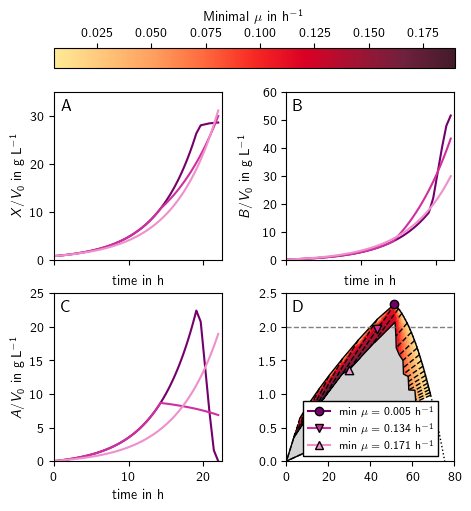

In [10]:
dirnames = ["177","184","186"] # SOLUTION SPACE 5
dirlabels = dirnames
linestyles = ["-"]*10
markers = ["o","v","^"]
colors = ["#b8da93","#32a1a2","#15396b"][::-1]
colors = ["#edbedd","#ef8fcc","#e65bb7","#d02f9f","#a0007e","#75006a"][::-2] # FLASH
solution_space_nr = '200'
factor = 1/1000*d4p3.metabolites.bt23dl_c.formula_weight
    
fig = plt.figure(dpi=100,figsize=(5.5,6))
axes = []
ctrl_t_offset = 4
for i in range(4):
    ax = fig.add_subplot(2,2,i+1,box_aspect=1)
    axes.append(ax)
    ax.set_xlim(0,22.5)
for ax in axes[:2]:
    ax.set_xticklabels([])

# Plot Simulations
if True:
    print(f"{'Process':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'P/Gfed':7} | {'Opt Time':7}")
    print(f"{' ':20} | {'g':7} | {'g/Lh':7} | {'g/L':7} | {'mol/mol':7} | {'g/g':7} | {'min':7}")
    print("---------------------------------------------------------------------------------")
    for nr, (dirname,label) in enumerate(zip(dirnames,dirlabels)):
        if "but" in dirname:
            df = pd.read_csv("../simulations/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
        else:
            df = pd.read_csv(f"../simulations/solution_space_{solution_space_nr}/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2(f"../simulations/solution_space_{solution_space_nr}/"+dirname+"/summary.txt")
        tmpcol = colors[nr]
        kwargs = {"color":tmpcol,"zorder":1,"linestyle":linestyles[nr]}
        axes[2].plot(df.t,df.S*d4p3.metabolites.acoin_c.formula_weight/1000,label=f"{np.min(df.q_X):.3f}",**kwargs)
        axes[0].plot(df.t,df.X,**kwargs)
        axes[1].plot(df.t,df.P*d4p3.metabolites.bt23dl_c.formula_weight/1000,**kwargs)
        tmp_P = df.P.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
        tmp_Pt = df.P.values[-1]/df.V.values[-1]/df.t.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
        tmp_PV = df.P.values[-1]/df.V.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
        axes[3].scatter(tmp_PV,tmp_Pt,marker=markers[nr],edgecolor="k",color=tmpcol)
        axes[3].plot([-10],[0],color=tmpcol,marker=markers[nr],label=r"min $\mu=$"+f" {np.min(df.q_X):.3f}"+r" h$^{-1}$",markeredgecolor="k")
        tmp_PG = df.P.values[-1]/((df.V.values[-1]-df.V.values[0])*c_G)
        tmp_PgGg = tmp_PG*d4p3.metabolites.bt23dl_c.formula_weight/d4p3.metabolites.glc__D_e.formula_weight
        print(f"""{dirname:20} | {tmp_P:>7.2f} | {tmp_Pt:7.2f} | {tmp_PV:7.2f} | {tmp_PG:7.2f} | {tmp_PgGg:7.2f} | {sum_dic['Time Elapsed in min'][0]:7.2f}""")
        
# Axes Labels
if True:
    axes[2].set_ylabel(r"$A/V_0$ in g\;L$^{-1}$")
    axes[0].set_ylabel(r"$X/V_0$ in g\;L$^{-1}$")
    axes[1].set_ylabel(r"$B/V_0$ in g\;L$^{-1}$")
    axes[2].set_ylim(0,25)
    axes[0].set_ylim(0,35)
    axes[1].set_ylim(0,60)
    axes[3].set_ylim(0,2.5)
    axes[3].set_xlim(0,80)
    axes[0].set_title("\n")
    for ax in axes[0:3]:
        ax.set_xlabel("time in h")
    
# SOLUTION SPACE
if True:
    #-- SOLUTION SPACE OUTLINE
    if True:

        lowX = []
        lowY = []
        for i in range(PV_PVs[:,0].flatten().shape[0]):
            for j, k in zip(PV_PVs[i,::-1].flatten(),Pt_Pts[i,::-1].flatten()):
                a = np.array(j,k)
                if np.isfinite(a):
                    lowX.append(j)
                    lowY.append(k)
                    break
        lowX = np.array(lowX)
        lowY = np.array(lowY)
        # upper soluction space bound
        axes[3].plot(PV_PVs[:,0].flatten(),Pt_Pts[:,0],color="k",zorder=.5,linewidth=1)
        # lower solution space bound
        axes[3].plot(lowX,lowY,color="k",zorder=.5,linewidth=1,linestyle="-")
        # fill area above solution space with white
        axes[3].fill_between(PV_PVs[:,0].flatten(),np.ones(PV_PVs[:,0].flatten().shape)*100,Pt_Pts[:,0],color="w",linewidth=0,zorder=0)
        
    #--- TIME LABELS
    if True:
        pareto_X = []
        pareto_Y = []
        r = .5
        x_offset = np.zeros(PV_PVs.shape[0])
        y_offset = np.zeros(PV_PVs.shape[0])
        x_offset[8] = -.05
        y_offset[8] = -.05
        # x_offset[13] = .3
        # y_offset[13] = .3
        x_offset[25] = .3
        y_offset[25] = .3

        cutoff = 8
        for a,a1,b,b1,c,xo, yo in zip(PV_PVs.swapaxes(1,0)[0,cutoff:],
                                      PV_PVs.swapaxes(1,0)[1,cutoff:],
                                      Pt_Pts.swapaxes(1,0)[0,cutoff:],
                                      Pt_Pts.swapaxes(1,0)[1,cutoff:],
                                      [f"{i:.0f} h" for i in PV_tends[cutoff:,0]],x_offset[cutoff:],y_offset[cutoff:]):
            pareto_X.append(a)
            pareto_Y.append(b)
            if c not in ["67 h","61 h","55 h","49 h"]:
                angle = 180+ calculate_angle(a,b,a1,b1,mx=80,my=2.5)
                xo = (xo+r)*80*factor*np.cos(math.radians(angle))
                yo = (yo+r)*2.5*factor*np.sin(math.radians(angle))
                # ax1.text(a+xo,b+yo,c,color="k",zorder=2,fontsize=7,rotation=angle,ha="center",va="center")
            else:
                pass
        pareto_X = np.array(pareto_X)
        pareto_Y = np.array(pareto_Y)

    #-- PLOT CONTOUR
    for i in range(PV_PVs[:,0].flatten().shape[0]):
        X = []
        Y = []
        Z = []
        i = PV_PVs[:,0].flatten().shape[0]-i-1
        for xx, yy, zz in zip(PV_PVs[i:i+2,:].flatten(),Pt_Pts[i:i+2,:].flatten(),PV_qOmaxes[i:i+2,:].flatten()):
            a = np.array([xx,yy,zz])
            if np.all(np.isfinite(a)):
                X.append(xx)
                Y.append(yy)
                Z.append(zz)
        try:
            axes[3].tricontourf(X, Y, Z, cmap=cmapXX,vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]),zorder=-10,levels=11)
        except:
            pass
    axes[3].plot([0,39.8],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    axes[3].plot([50,51.7],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    axes[3].plot([58.6,80],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")

    #-- FIT
    if True:
        def fun_to_min(theta):
            a,b,c= theta
            fitY = pareto_X**2*a + pareto_X*b + c
            loss = np.sum((pareto_Y-fitY)**2)
            return loss

        sol = minimize(fun = fun_to_min,
                x0  = [1,1,1],
                method = 'Nelder-Mead',
                options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5}
                )
        fitX = np.linspace(pareto_X[0],80,101)
        a,b,c= sol.x
        fitY = fitX**2*a + fitX*b + c
        axes[3].plot(fitX,fitY,zorder=0,linewidth=1,color="k",linestyle=":")

    #-- TIME LINES
    if True:
        XUP, YUP = PV_PVs[:,0].flatten(),Pt_Pts[:,0].flatten()
        XLO, YLO = lowX,lowY
        for nr, (x1,y1,x2,y2,XX,YY) in enumerate(zip(XUP,YUP,XLO,YLO,PV_PVs,Pt_Pts)):
            x = 0
            y = calculate_y([x1,x2],[y1,y2],x)
            mask = np.isfinite(XX)&np.isfinite(YY)
            if nr==0 or nr == 25:
                plotX, plotY = np.concatenate([XX*mask,[x2,x]]),np.concatenate([YY*mask,[y2,y]])
                axes[3].plot([x2,x],[y2,y],color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="-")
            else:
                plotX, plotY = XX*mask,YY*mask
            axes[3].plot(plotX,plotY,color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="--")
        lowX = np.append(0,lowX)
        lowY = np.append(0,lowY)
        axes[3].fill_between(lowX,lowY,[calculate_y([x1,x2],[y1,y2],i) for i in lowX],zorder=0,color="lightgrey",linewidth=0)

        lowY = [calculate_y([x1,x2],[y1,y2],i) for i in lowX]
        lowY = np.concatenate([lowY,fitY[fitX > np.max(lowX)]])
        lowX = np.concatenate([lowX,fitX[fitX > np.max(lowX)]])
        
# COLORBAR
if True:
    norm = Normalize(vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]))
    scalar_mappable = cm.ScalarMappable(cmap=cmapXX, norm=norm)
    scalar_mappable.set_array([])  # Set an empty array
    fig.colorbar(scalar_mappable, ax=axes, orientation='horizontal', location='top', aspect=20,label=r'Minimal $\mu$ in h$^{-1}$',shrink=.94)
    
# Legend
if 0:
    fig.align_ylabels()
    fig.tight_layout()
    ax1_pos = axes[0].get_position()
    ax2_pos = axes[1].get_position()
    legend_x = (ax1_pos.x0 + ax2_pos.x1) / 2
    fig.legend(loc='center', bbox_to_anchor=(legend_x, .93), ncol=5)
    fig.tight_layout()
    
# Panel Legends
if True:
    for name, ax in zip(['A','B','C','D','E','F'],axes):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
axes[3].legend(fontsize=8,loc="lower center",framealpha=1)

fig.align_xlabels()
fig.align_ylabels()

plt.show()

# SUPPLEMENTARY FIGURE S4

Process              | P       | P/t     | P/V     | P/Gfed  | P/Gfed  | Time   
                     | g       | g/Lh    | g/L     | mol/mol | g/g     | h      
---------------------------------------------------------------------------------
166                  |   41.32 |    2.11 |   43.35 |    0.51 |    0.25 |   20.50
217                  |   49.16 |    2.09 |   49.16 |    0.49 |    0.25 |   23.50
237                  |   52.43 |    2.10 |   52.43 |    0.52 |    0.26 |   25.00


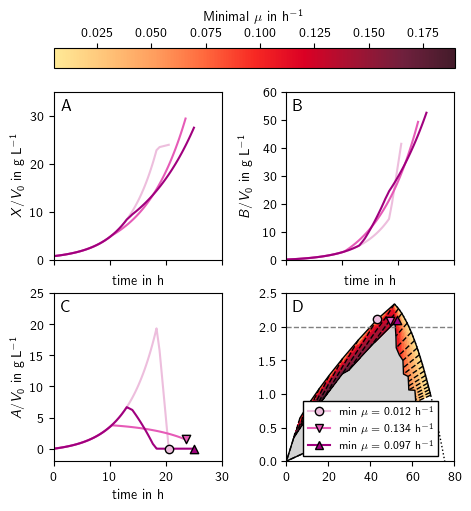

In [11]:
dirnames = ["166","217","237"] # SOLUTION SPACE 5
dirlabels = dirnames
linestyles = ["-"]*10
markers = ["o","v","^"]*10
colors = ["#b8da93","#32a1a2","#15396b"][::-1]
colors = ["#edbedd","#ef8fcc","#e65bb7","#d02f9f","#a0007e","#75006a"][::2] # FLASH
solution_space_nr = '200'
    
fig = plt.figure(dpi=100,figsize=(5.5,6))
axes = []
ctrl_t_offset = 4
for i in range(4):
    ax = fig.add_subplot(2,2,i+1,box_aspect=1)
    axes.append(ax)
    ax.set_xlim(0,30)
for ax in axes[:2]:
    ax.set_xticklabels([])

# Plot Simulations
if True:
    print(f"{'Process':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'P/Gfed':7} | {'Time':7}")
    print(f"{' ':20} | {'g':7} | {'g/Lh':7} | {'g/L':7} | {'mol/mol':7} | {'g/g':7} | {'h':7}")
    print("---------------------------------------------------------------------------------")
    for nr, (dirname,label) in enumerate(zip(dirnames,dirlabels)):
        if "but" in dirname:
            df = pd.read_csv("../simulations/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
        else:
            df = pd.read_csv(f"../simulations/solution_space_{solution_space_nr}/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2(f"../simulations/solution_space_{solution_space_nr}/"+dirname+"/summary.txt")
        tmpcol = colors[nr]
        kwargs = {"color":tmpcol,"zorder":1,"linestyle":linestyles[nr]}
        
        axes[2].plot(df.t,df.S*d4p3.metabolites.acoin_c.formula_weight/1000,label=f"{np.min(df.q_X):.3f}",**kwargs)
        axes[2].scatter(df.t.values[-1],df.S.values[-1]*d4p3.metabolites.acoin_c.formula_weight/1000,label=f"{np.min(df.q_X):.3f}",marker=markers[nr],color=tmpcol,edgecolor="k",zorder=2)
        axes[0].plot(df.t,df.X,**kwargs)
        axes[1].plot(df.t,df.P*d4p3.metabolites.bt23dl_c.formula_weight/1000,**kwargs)
        
        tmp_P = df.P.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
        tmp_Pt = df.P.values[-1]/df.V.values[-1]/df.t.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
        tmp_PV = df.P.values[-1]/df.V.values[-1]*d4p3.metabolites.bt23dl_c.formula_weight/1000
        axes[3].scatter(tmp_PV,tmp_Pt,marker=markers[nr],edgecolor="k",color=tmpcol)
        axes[3].plot([-10],[0],color=tmpcol,marker=markers[nr],label=r"min $\mu=$"+f" {np.min(df.q_X):.3f}"+r" h$^{-1}$",markeredgecolor="k")
        tmp_PG = df.P.values[-1]/((df.V.values[-1]-df.V.values[0])*c_G)
        tmp_PgGg = tmp_PG*d4p3.metabolites.bt23dl_c.formula_weight/d4p3.metabolites.glc__D_e.formula_weight
        print(f"""{dirname:20} | {tmp_P:>7.2f} | {tmp_Pt:7.2f} | {tmp_PV:7.2f} | {tmp_PG:7.2f} | {tmp_PgGg:7.2f} | {df.t.values[-1]:7.2f}""")
        
# Axes Labels
if True:
    axes[2].set_ylabel(r"$A/V_0$ in g\;L$^{-1}$")
    axes[0].set_ylabel(r"$X/V_0$ in g\;L$^{-1}$")
    axes[1].set_ylabel(r"$B/V_0$ in g\;L$^{-1}$")
    axes[2].set_ylim(-2,25)
    axes[0].set_ylim(0,35)
    axes[1].set_ylim(0,60)
    axes[0].set_title("\n")
    axes[3].set_ylim(0,2.5)
    axes[3].set_xlim(0,80)

    for ax in axes[0:3]:
        ax.set_xlabel("time in h")
        
# SOLUTION SPACE
if True:
    #-- SOLUTION SPACE OUTLINE
    if True:

        lowX = []
        lowY = []
        for i in range(PV_PVs[:,0].flatten().shape[0]):
            for j, k in zip(PV_PVs[i,::-1].flatten(),Pt_Pts[i,::-1].flatten()):
                a = np.array(j,k)
                if np.isfinite(a):
                    lowX.append(j)
                    lowY.append(k)
                    break
        lowX = np.array(lowX)
        lowY = np.array(lowY)
        # upper soluction space bound
        axes[3].plot(PV_PVs[:,0].flatten(),Pt_Pts[:,0],color="k",zorder=.5,linewidth=1)
        # lower solution space bound
        axes[3].plot(lowX,lowY,color="k",zorder=.5,linewidth=1,linestyle="-")
        # fill area above solution space with white
        axes[3].fill_between(PV_PVs[:,0].flatten(),np.ones(PV_PVs[:,0].flatten().shape)*100,Pt_Pts[:,0],color="w",linewidth=0,zorder=0)

    #-- PLOT CONTOUR
    for i in range(PV_PVs[:,0].flatten().shape[0]):
        X = []
        Y = []
        Z = []
        i = PV_PVs[:,0].flatten().shape[0]-i-1
        for xx, yy, zz in zip(PV_PVs[i:i+2,:].flatten(),Pt_Pts[i:i+2,:].flatten(),PV_qOmaxes[i:i+2,:].flatten()):
            a = np.array([xx,yy,zz])
            if np.all(np.isfinite(a)):
                X.append(xx)
                Y.append(yy)
                Z.append(zz)
        try:
            axes[3].tricontourf(X, Y, Z, cmap=cmapXX,vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]),zorder=-10,levels=11)
        except:
            pass
    axes[3].plot([0,39.8],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    axes[3].plot([50,51.7],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    axes[3].plot([58.6,80],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")

    #-- FIT
    if True:
        def fun_to_min(theta):
            a,b,c= theta
            fitY = pareto_X**2*a + pareto_X*b + c
            loss = np.sum((pareto_Y-fitY)**2)
            return loss

        sol = minimize(fun = fun_to_min,
                x0  = [1,1,1],
                method = 'Nelder-Mead',
                options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5}
                )
        fitX = np.linspace(pareto_X[0],80,101)
        a,b,c= sol.x
        fitY = fitX**2*a + fitX*b + c
        axes[3].plot(fitX,fitY,zorder=0,linewidth=1,color="k",linestyle=":")

    #-- TIME LINES
    if True:
        XUP, YUP = PV_PVs[:,0].flatten(),Pt_Pts[:,0].flatten()
        XLO, YLO = lowX,lowY
        for nr, (x1,y1,x2,y2,XX,YY) in enumerate(zip(XUP,YUP,XLO,YLO,PV_PVs,Pt_Pts)):
            x = 0
            y = calculate_y([x1,x2],[y1,y2],x)
            mask = np.isfinite(XX)&np.isfinite(YY)
            if nr==0 or nr == 25:
                plotX, plotY = np.concatenate([XX*mask,[x2,x]]),np.concatenate([YY*mask,[y2,y]])
                axes[3].plot([x2,x],[y2,y],color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="-")
            else:
                plotX, plotY = XX*mask,YY*mask
            axes[3].plot(plotX,plotY,color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="--")
        lowX = np.append(0,lowX)
        lowY = np.append(0,lowY)
        axes[3].fill_between(lowX,lowY,[calculate_y([x1,x2],[y1,y2],i) for i in lowX],zorder=0,color="lightgrey",linewidth=0)

        lowY = [calculate_y([x1,x2],[y1,y2],i) for i in lowX]
        lowY = np.concatenate([lowY,fitY[fitX > np.max(lowX)]])
        lowX = np.concatenate([lowX,fitX[fitX > np.max(lowX)]])
    
# COLORBAR
if True:
    norm = Normalize(vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]))
    scalar_mappable = cm.ScalarMappable(cmap=cmapXX, norm=norm)
    scalar_mappable.set_array([])  # Set an empty array
    fig.colorbar(scalar_mappable, ax=axes, orientation='horizontal', location='top', aspect=20,label=r'Minimal $\mu$ in h$^{-1}$',shrink=.94)
    
# Panel Legends
if True:
    for name, ax in zip(['A','B','C','D','E','F'],axes):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
        
axes[3].legend(fontsize=8,loc="lower center",framealpha=1)

fig.align_xlabels()
fig.align_ylabels()

plt.show()

# FIGURE 5

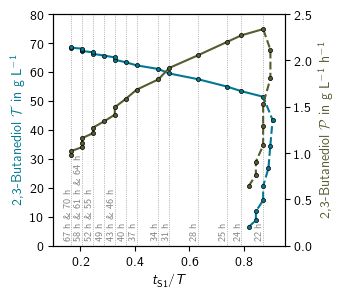

In [12]:
Tcolor = "#007891"
Pcolor = "#565b30"

j = 0
s = ""
ss = []
for i,t in zip(Pt_tS1s[:,0]/Pt_tends[:,0],Pt_tends[:,0]):
    if np.isclose(i,j,atol=1e-2):
        s += f" \& {t:.0f} h"
    else:
        ss.append(s)
        s = f"{t:.0f} h"
    j = i
ss.append(s)

fig = plt.figure(dpi=100,figsize=(3.5,3.5))
ax2 = fig.add_subplot(111,box_aspect=1)
ax1 = fig.add_subplot(111,box_aspect=1)
ax1.set_facecolor("None")
ax2.set_facecolor("None")
ax1.tick_params(bottom=0, top=0, left=0, right=1, labelbottom=0, labeltop=0, labelleft=0, labelright=1)
ax1.yaxis.set_label_position("right")
xlim = .1,.95
ax1.set_xlim(*xlim)
ax2.set_xlim(*xlim)

k = 9
ax1.plot(Pt_tS1s[:k,0]/Pt_tends[:k,0],Pt_Pts[:k,0],color=Pcolor,linestyle="--")
ax2.plot(PV_tS1s[:k,0]/PV_tends[:k,0],PV_PVs[:k,0],color=Tcolor,linestyle="--")
k = 8
ax1.plot(Pt_tS1s[k:,0]/Pt_tends[k:,0],Pt_Pts[k:,0],color=Pcolor)
ax2.plot(PV_tS1s[k:,0]/PV_tends[k:,0],PV_PVs[k:,0],color=Tcolor)

ax1.scatter(Pt_tS1s[:,0]/Pt_tends[:,0],Pt_Pts[:,0],color=Pcolor,marker=".",edgecolor="k",zorder=3,linewidths=.5)
ax2.scatter(PV_tS1s[:,0]/PV_tends[:,0],PV_PVs[:,0],color=Tcolor,marker=".",edgecolor="k",zorder=3,linewidths=.5)

ii = [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 23, 25]
for n,i in enumerate(ii): 
    f"{Pt_tends[i,0]:.0f} h "
    ax1.text(Pt_tS1s[i,0]/Pt_tends[i,0]-.015,.05,ss[n+5],zorder=2,fontsize=7,rotation=90,ha="center",va="bottom",color="grey")
    ax2.axvline(Pt_tS1s[i,0]/Pt_tends[i,0],color="grey",linewidth=.5,linestyle=":",zorder=-1)

ax2.set_xlabel(r"$t_{\rm S1}/T$")
ax2.set_ylabel(r"2,3-Butanediol $\mathcal{T}$ in g\;L$^{-1}$")
ax1.set_ylabel(r"2,3-Butanediol $\mathcal{P}$ in g\;L$^{-1}$\;h$^{-1}$")
ax1.yaxis.label.set_color(Pcolor)
ax2.yaxis.label.set_color(Tcolor)
ax1.set_ylim(0,2.5)
ax2.set_ylim(0,80)


plt.tight_layout()
plt.show()

# FIGURE 4

paper_3C
paper_S3
77
83


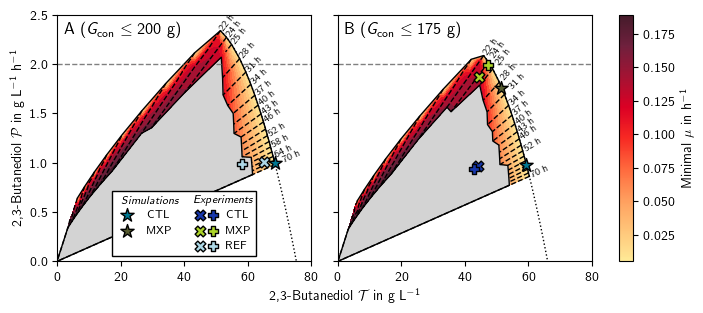

In [13]:
fig = plt.figure(dpi=100,figsize=(7.5,3.5))
# ax1 = plt.subplot(121,box_aspect=1)
# ax2 = plt.subplot(122,box_aspect=1)
gs = gridspec.GridSpec(1, 3, width_ratios=[9, 9, .5])  # 9:9:2 ratio
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
factor = 1/1000*d4p3.metabolites.bt23dl_c.formula_weight

# Gcon = 200 g
if True:
    simshape = 11
    solution_space_nr = '005'
    sims = [solution_space_nr]
    base_path = "/home/users/mgotsmy/julia/240426_extended_boku_model/simulations/"
    experimental_simulations = ["ext_but_043"]
    experimental_simulations_labels = ["Control",r"Maximize $\mathcal{P}$"]
    experimental_simulations_colors = ["#007891","#565b30"]
    
    for nr in sims:
        # header1 = f"{'Process':20} | {'Status':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'P/Gfed':7} | {'T_end':7} | {'qX_min':7}"
        # header2 = f"{' ':20} | {'':20} | {'mmol':7} | {'mmol/h':7} | {'mmol/L':7} | {'mol/mol':7} | {'g/g':7} | {'h':7} | {'1/h':7}"
        # printer(header1,top=1)
        # printer(header2,bottom=1)

        folder = f"{base_path}solution_space_{solution_space_nr}"
        PVs, Pts, tends, qOmaxes, return_PVs, valid_names, tS1s = get_lists(folder,verbose=False)

        qOmaxes = np.array(qOmaxes)#.reshape(-1,6)
        PVs     = np.array(PVs)#.reshape(-1,6)
        Pts     = np.array(Pts)#.reshape(-1,6)
        tends   = np.array(tends)#.reshape(-1,6)
        return_PVs = np.array(return_PVs)#.reshape(-1,6)
        valid_names = np.array(valid_names)
        PV_qOmaxes = qOmaxes[return_PVs].reshape(-1,simshape)
        PV_PVs = PVs[return_PVs].reshape(-1,simshape)
        PV_Pts = Pts[return_PVs].reshape(-1,simshape)
        PV_tends = tends[return_PVs].reshape(-1,simshape)
        PV_names = valid_names[return_PVs].reshape(-1,simshape)

        Pt_qOmaxes = qOmaxes[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_Pts = Pts[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_PVs = PVs[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_tends = tends[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_names = valid_names[np.invert(return_PVs)].reshape(-1,simshape)

        assert np.all(np.isclose(np.nan_to_num(Pt_tends),np.nan_to_num(PV_tends)))
        assert np.all(np.isclose(np.nan_to_num(Pt_qOmaxes),np.nan_to_num(PV_qOmaxes),atol=1e-3))

    #-- SOLUTION SPACE OUTLINE
    if True:
        lowX = []
        lowY = []
        for i in range(PV_PVs[:,0].flatten().shape[0]):
            for j, k in zip(PV_PVs[i,::-1].flatten(),Pt_Pts[i,::-1].flatten()):
                a = np.array(j,k)
                if np.isfinite(a):
                    lowX.append(j)
                    lowY.append(k)
                    break
        lowX = np.array(lowX)
        lowY = np.array(lowY)
        # upper soluction space bound
        ax1.plot(PV_PVs[:,0].flatten(),Pt_Pts[:,0],color="k",zorder=.5,linewidth=1)
        # lower solution space bound
        ax1.plot(lowX,lowY,color="k",zorder=.5,linewidth=1,linestyle="-")
        # fill area above solution space with white
        ax1.fill_between(PV_PVs[:,0].flatten(),np.ones(PV_PVs[:,0].flatten().shape)*100,Pt_Pts[:,0],color="w",linewidth=0,zorder=0)

    #-- PLOT CONTOUR
    for i in range(PV_PVs[:,0].flatten().shape[0]):
        X = []
        Y = []
        Z = []
        i = PV_PVs[:,0].flatten().shape[0]-i-1
        for xx, yy, zz in zip(PV_PVs[i:i+2,:].flatten(),Pt_Pts[i:i+2,:].flatten(),PV_qOmaxes[i:i+2,:].flatten()):
            a = np.array([xx,yy,zz])
            if np.all(np.isfinite(a)):
                X.append(xx)
                Y.append(yy)
                Z.append(zz)
        try:
            ax1.tricontourf(X, Y, Z, cmap=cmapXX,vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]),zorder=-10,levels=11)
        except:
            pass

    #-- TIME LABELS
    if True:
        pareto_X = []
        pareto_Y = []
        r = .5
        x_offset = np.zeros(PV_PVs.shape[0])
        y_offset = np.zeros(PV_PVs.shape[0])
        x_offset[8] = -.05
        y_offset[8] = -.05
        # x_offset[13] = .3
        # y_offset[13] = .3
        x_offset[25] = .3
        y_offset[25] = .3

        cutoff = 8
        for a,a1,b,b1,c,xo, yo in zip(PV_PVs.swapaxes(1,0)[0,cutoff:],
                                      PV_PVs.swapaxes(1,0)[1,cutoff:],
                                      Pt_Pts.swapaxes(1,0)[0,cutoff:],
                                      Pt_Pts.swapaxes(1,0)[1,cutoff:],
                                      [f"{i:.0f} h" for i in PV_tends[cutoff:,0]],x_offset[cutoff:],y_offset[cutoff:]):
            pareto_X.append(a)
            pareto_Y.append(b)
            if c not in ["67 h","61 h","55 h","49 h"]:
                angle = 180+ calculate_angle(a,b,a1,b1,mx=80,my=2.5)
                xo = (xo+r)*80*factor*np.cos(math.radians(angle))
                yo = (yo+r)*2.5*factor*np.sin(math.radians(angle))
                ax1.text(a+xo,b+yo,c,color="k",zorder=2,fontsize=7,rotation=angle,ha="center",va="center")
            else:
                pass
        pareto_X = np.array(pareto_X)
        pareto_Y = np.array(pareto_Y)

    #-- COLORBAR
    if 0:
        norm = Normalize(vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]))
        scalar_mappable = cm.ScalarMappable(cmap=cmapXX, norm=norm)
        scalar_mappable.set_array([])  # Set an empty array
        divider = make_axes_locatable(ax1)
        cax = divider.new_vertical(size = '3%', pad = -1.4)
        fig.add_axes(cax)
        plt.colorbar(scalar_mappable, cax=cax, orientation='horizontal', label=r'Minimal $\mu$ in h$^{-1}$',pad=-10)

    #-- EXPERIMENTAL MARKERS
    if True:
        for run in ["paper_3C","paper_S3"]:
            tmp = get_run(xls,run)
            kwargs = get_plot_kwargs(run)
            loc = -1
            kwargs["s"] = 60
            kwargs["zorder"] = 5
            kwargs["linewidths"] = 1

            tcorr = tmp.t.values-tswitch_dict[run]+tnorm_dict[run]
            xcorr = tmp.X/tmp.V.values[0]*1000 # g/L
            gcorr = tmp.Gup/tmp.V.values[0]*1000 # g/L
            bcorr = tmp.B/tmp.V.values[0]*1000 # g/L
            acorr = tmp.A/tmp.V.values[0]*1000 # g/L
            run_PV = bcorr.values[loc]
            run_Pt = bcorr.values[loc]/tcorr[loc]
            tcorrdelta = -tswitch_dict[run]+tnorm_dict[run]
            Gup = tmp.Gup.values[loc]
            Gupmol = Gup/d4p3.metabolites.glc__D_e.formula_weight # g / (g/mol)
            B = tmp.B.values[loc]
            Bmol = B/d4p3.metabolites.bt23dl_c.formula_weight

            ax1.scatter(run_PV,run_Pt,**kwargs)
        p1 = ax1.scatter(-100,-100,color="w",edgecolor="w",label=r"$~$")
        # p2 = ax1.scatter(-100,-100,color="w",edgecolor="w",label=r"$Experiments$")
        p3A = ax1.scatter(-100,-100,color="#1737ab",edgecolor="k",label="Control",marker="X",s=60)
        p3B = ax1.scatter(-100,-100,color="#1737ab",edgecolor="k",label="Control",marker="P",s=60)
        p4A = ax1.scatter(-100,-100,color="#acd429",edgecolor="k",label=r"Maximize $\mathcal{P}$",marker="X",s=60)
        p4B = ax1.scatter(-100,-100,color="#acd429",edgecolor="k",label=r"Maximize $\mathcal{P}$",marker="P",s=60)
        p5A = ax1.scatter(-100,-100,color="lightblue",edgecolor="k",label="Erian et al.",marker="X",s=60)
        p5B = ax1.scatter(-100,-100,color="lightblue",edgecolor="k",label="Erian et al.",marker="P",s=60)

    # SIMULATION MARKERS
    if True:
        plt_objects = []
        p6 = ax1.scatter(0,-100,color="w",edgecolor="w",label=r"\textit{Simulations}",marker="*",s=100)
        for dirname, lab, col in zip(experimental_simulations,experimental_simulations_labels,experimental_simulations_colors):
            if len(dirname) == 3:
                simulation_path = base_path+"/solution_space_"+solution_space_nr+"/"
            else:
                simulation_path = base_path+"/"
            df = pd.read_csv(simulation_path+dirname+"/df.csv")
            if "047" in dirname:
                loc = -1 #np.argmin(np.abs(df.t.values-23.8))
            elif "043" in dirname:
                loc = -1
            else:
                print("SIMULATION NOT KNOW. LOC NOT CORRECTLY DEFINED")

            sum_dic, sum_df = parse_summary_file2(simulation_path+dirname+"/summary.txt")
            run_PV = df.P.values[loc]/df.V.values[loc]/1000*d4p3.metabolites.bt23dl_c.formula_weight
            run_Pt = df.P.values[loc]/df.V.values[loc]/df.t.values[loc]/1000*d4p3.metabolites.bt23dl_c.formula_weight
            tcorr = df.t.values[loc]
            tmp = ax1.scatter(run_PV,run_Pt,edgecolor="k",color=col,marker="*",s=100,label=lab,zorder=10)
            plt_objects.append(tmp)

            Gup = (df.V.values[loc]-df.V.values[0])*c_G # mmol
            Gup_g = Gup/1000*d4p3.metabolites.glc__D_e.formula_weight
            P_g = df.P.values[loc]/1000*d4p3.metabolites.bt23dl_c.formula_weight

    ax1.plot([0,39.8],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    ax1.plot([50,51.7],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    ax1.plot([58.6,80],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")

    #-- FIT
    if True:
        def fun_to_min(theta):
            a,b,c= theta
            fitY = pareto_X**2*a + pareto_X*b + c
            loss = np.sum((pareto_Y-fitY)**2)
            return loss

        sol = minimize(fun = fun_to_min,
                x0  = [1,1,1],
                method = 'Nelder-Mead',
                options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5}
                )
        fitX = np.linspace(pareto_X[0],80,101)
        a,b,c= sol.x
        fitY = fitX**2*a + fitX*b + c
        ax1.plot(fitX,fitY,zorder=0,linewidth=1,color="k",linestyle=":")

    #-- TIME LINES
    if True:
        XUP, YUP = PV_PVs[:,0].flatten(),Pt_Pts[:,0].flatten()
        XLO, YLO = lowX,lowY
        for nr, (x1,y1,x2,y2,XX,YY) in enumerate(zip(XUP,YUP,XLO,YLO,PV_PVs,Pt_Pts)):
            x = 0
            y = calculate_y([x1,x2],[y1,y2],x)
            mask = np.isfinite(XX)&np.isfinite(YY)
            if nr==0 or nr == 25:
                plotX, plotY = np.concatenate([XX*mask,[x2,x]]),np.concatenate([YY*mask,[y2,y]])
                ax1.plot([x2,x],[y2,y],color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="-")
            else:
                plotX, plotY = XX*mask,YY*mask
            ax1.plot(plotX,plotY,color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="--")
        lowX = np.append(0,lowX)
        lowY = np.append(0,lowY)
        ax1.fill_between(lowX,lowY,[calculate_y([x1,x2],[y1,y2],i) for i in lowX],zorder=0,color="lightgrey",linewidth=0)

        lowY = [calculate_y([x1,x2],[y1,y2],i) for i in lowX]
        lowY = np.concatenate([lowY,fitY[fitX > np.max(lowX)]])
        lowX = np.concatenate([lowX,fitX[fitX > np.max(lowX)]])
    
    
# Gcon = 175.23 g
if 1:
    simshape = 11
    solution_space_nr = '175'
    sims = [solution_space_nr]
    base_path = "../simulations/"
    experimental_simulations = ["fb_ctl","fb_mxp"]
    experimental_simulations_labels = ["Control",r"Maximize $\mathcal{P}$"]
    experimental_simulations_colors = ["#007891","#565b30"]
    
    for nr in sims:
        header1 = f"{'Process':20} | {'Status':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'P/Gfed':7} | {'T_end':7} | {'qX_min':7}"
        header2 = f"{' ':20} | {'':20} | {'mmol':7} | {'mmol/h':7} | {'mmol/L':7} | {'mol/mol':7} | {'g/g':7} | {'h':7} | {'1/h':7}"
        # printer(header1,top=1)
        # printer(header2,bottom=1)

        folder = f"{base_path}solution_space_{solution_space_nr}"
        PVs, Pts, tends, qOmaxes, return_PVs, valid_names, tS1s = get_lists(folder,verbose=False)

        qOmaxes = np.array(qOmaxes)#.reshape(-1,6)
        PVs     = np.array(PVs)#.reshape(-1,6)
        Pts     = np.array(Pts)#.reshape(-1,6)
        tends   = np.array(tends)#.reshape(-1,6)
        return_PVs = np.array(return_PVs)#.reshape(-1,6)
        valid_names = np.array(valid_names)
        PV_qOmaxes = qOmaxes[return_PVs].reshape(-1,simshape)
        PV_PVs = PVs[return_PVs].reshape(-1,simshape)
        PV_Pts = Pts[return_PVs].reshape(-1,simshape)
        PV_tends = tends[return_PVs].reshape(-1,simshape)
        PV_names = valid_names[return_PVs].reshape(-1,simshape)

        Pt_qOmaxes = qOmaxes[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_Pts = Pts[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_PVs = PVs[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_tends = tends[np.invert(return_PVs)].reshape(-1,simshape)
        Pt_names = valid_names[np.invert(return_PVs)].reshape(-1,simshape)

        assert np.all(np.isclose(np.nan_to_num(Pt_tends),np.nan_to_num(PV_tends)))
        assert np.all(np.isclose(np.nan_to_num(Pt_qOmaxes),np.nan_to_num(PV_qOmaxes),atol=1e-3))
    
    #-- SOLUTION SPACE OUTLINE
    if True:
        lowX = []
        lowY = []
        for i in range(PV_PVs[:,0].flatten().shape[0]):
            for j, k in zip(PV_PVs[i,::-1].flatten(),Pt_Pts[i,::-1].flatten()):
                a = np.array(j,k)
                if np.isfinite(a):
                    lowX.append(j)
                    lowY.append(k)
                    break
        lowX = np.array(lowX)
        lowY = np.array(lowY)
        # upper soluction space bound
        ax2.plot(PV_PVs[:,0].flatten(),Pt_Pts[:,0],color="k",zorder=.5,linewidth=1)
        # lower solution space bound
        ax2.plot(lowX,lowY,color="k",zorder=.5,linewidth=1,linestyle="-")
        # fill area above solution space with white
        ax2.fill_between(PV_PVs[:,0].flatten(),np.ones(PV_PVs[:,0].flatten().shape)*100,Pt_Pts[:,0],color="w",linewidth=0,zorder=0)

    #-- PLOT CONTOUR
    for i in range(PV_PVs[:,0].flatten().shape[0]):
        X = []
        Y = []
        Z = []
        i = PV_PVs[:,0].flatten().shape[0]-i-1
        for xx, yy, zz in zip(PV_PVs[i:i+2,:].flatten(),Pt_Pts[i:i+2,:].flatten(),PV_qOmaxes[i:i+2,:].flatten()):
            a = np.array([xx,yy,zz])
            if np.all(np.isfinite(a)):
                X.append(xx)
                Y.append(yy)
                Z.append(zz)
        try:
            ax2.tricontourf(X, Y, Z, cmap=cmapXX,vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]),zorder=-10,levels=11)
        except:
            pass

    #-- TIME LABELS
    if True:
        pareto_X = []
        pareto_Y = []
        r = .5
        x_offset = np.zeros(PV_PVs.shape[0])
        y_offset = np.zeros(PV_PVs.shape[0])
        # x_offset[7] = -.05
        # y_offset[7] = -.05
        x_offset[9:11] = .2
        y_offset[9:11] = .2
        x_offset[11] = .1
        y_offset[11] = .1
        x_offset[12] = .3
        y_offset[12] = .3
        x_offset[21] = .3
        y_offset[21] = .3

        cutoff = 8
        for a,a1,b,b1,c,xo, yo in zip(PV_PVs.swapaxes(1,0)[0,cutoff:],
                                      PV_PVs.swapaxes(1,0)[1,cutoff:],
                                      Pt_Pts.swapaxes(1,0)[0,cutoff:],
                                      Pt_Pts.swapaxes(1,0)[1,cutoff:],
                                      [f"{i:.0f} h" for i in PV_tends[cutoff:,0]],x_offset[cutoff:],y_offset[cutoff:]):
            pareto_X.append(a)
            pareto_Y.append(b)
            if c not in ["67 h","61 h","55 h","49 h","58 h","64 h"]:
                angle = 180+ calculate_angle(a,b,a1,b1,mx=80,my=2.5)
                xo = (xo+r)*80*factor*np.cos(math.radians(angle))
                yo = (yo+r)*2.5*factor*np.sin(math.radians(angle))
                ax2.text(a+xo,b+yo,c,color="k",zorder=2,fontsize=7,rotation=angle,ha="center",va="center")
            else:
                pass
        pareto_X = np.array(pareto_X)
        pareto_Y = np.array(pareto_Y)

    #-- COLORBAR
    if 0:
        norm = Normalize(vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]))
        scalar_mappable = cm.ScalarMappable(cmap=cmapXX, norm=norm)
        scalar_mappable.set_array([])  # Set an empty array
        divider = make_axes_locatable(ax2)
        cax = divider.new_vertical(size = '3%', pad = -1.4)
        fig.add_axes(cax)
        ax2.colorbar(scalar_mappable, cax=cax, orientation='vertical', label=r'Minimal $\mu$ in h$^{-1}$',pad=-10)

    #-- EXPERIMENTAL MARKERS
    if True:
        for run in ['control_A', 'control_B', 'productivity_A', 'productivity_B']:
            tmp = get_run(xls,run)
            kwargs = get_plot_kwargs(run)
            loc = -1
            kwargs["s"] = 60
            kwargs["zorder"] = 5
            kwargs["linewidths"] = 1

            tcorr = tmp.t.values-tswitch_dict[run]+tnorm_dict[run]
            xcorr = tmp.X/tmp.V.values[0]*1000 # g/L
            gcorr = tmp.Gup/tmp.V.values[0]*1000 # g/L
            bcorr = tmp.B/tmp.V.values[0]*1000 # g/L
            acorr = tmp.A/tmp.V.values[0]*1000 # g/L
            run_PV = bcorr.values[loc]
            run_Pt = bcorr.values[loc]/tcorr[loc]
            tcorrdelta = -tswitch_dict[run]+tnorm_dict[run]
            Gup = tmp.Gup.values[loc]
            Gupmol = Gup/d4p3.metabolites.glc__D_e.formula_weight # g / (g/mol)
            B = tmp.B.values[loc]
            Bmol = B/d4p3.metabolites.bt23dl_c.formula_weight

            ax2.scatter(run_PV,run_Pt,**kwargs)
        p1 = ax2.scatter(-100,-100,color="w",edgecolor="w",label=r"$~$")
        p2 = ax2.scatter(-100,-100,color="w",edgecolor="w",label=r"$Experiments$")
        p3A = ax2.scatter(-100,-100,color="#1737ab",edgecolor="k",label="Control",marker="X",s=60)
        p3B = ax2.scatter(-100,-100,color="#1737ab",edgecolor="k",label="Control",marker="P",s=60)
        p4A = ax2.scatter(-100,-100,color="#acd429",edgecolor="k",label=r"Maximize $\mathcal{P}$",marker="X",s=60)
        p4B = ax2.scatter(-100,-100,color="#acd429",edgecolor="k",label=r"Maximize $\mathcal{P}$",marker="P",s=60)
        p5A = ax2.scatter(-100,-100,color="lightblue",edgecolor="k",label="Erian et al.",marker="X",s=60)
        p5B = ax2.scatter(-100,-100,color="lightblue",edgecolor="k",label="Erian et al.",marker="P",s=60)

    # SIMULATION MARKERS
    if True:
        plt_objects = []
        p6 = ax2.scatter(0,-100,color="w",edgecolor="w",label=r"\textit{Simulations}",marker="*",s=100)
        for dirname, lab, col in zip(experimental_simulations,experimental_simulations_labels,experimental_simulations_colors):
            if len(dirname) == 3:
                simulation_path = base_path+"/solution_space_"+solution_space_nr+"/"
            else:
                simulation_path = base_path+"/"
            df = pd.read_csv(simulation_path+dirname+"/df.csv")
            Gup = (df.V.values-df.V.values[0])*c_G # mmol
            Gup_g = Gup/1000*d4p3.metabolites.glc__D_e.formula_weight
            loc = np.argmin(np.abs(Gup_g-175.23))
            print(loc)

            sum_dic, sum_df = parse_summary_file2(simulation_path+dirname+"/summary.txt")
            run_PV = df.P.values[loc]/df.V.values[-1]/1000*d4p3.metabolites.bt23dl_c.formula_weight
            run_Pt = df.P.values[loc]/df.V.values[-1]/df.t.values[loc]/1000*d4p3.metabolites.bt23dl_c.formula_weight
            tcorr = df.t.values[loc]
            tmp = ax2.scatter(run_PV,run_Pt,edgecolor="k",color=col,marker="*",s=100,label=lab,zorder=10)
            plt_objects.append(tmp)



            P_g = df.P.values[loc]/1000*d4p3.metabolites.bt23dl_c.formula_weight

    ax2.plot([0,39.8],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")
    ax2.plot([50,80],[2,2],color="grey",zorder=.5,linewidth=1,linestyle="--")

    #-- FIT
    if True:
        def fun_to_min(theta):
            a,b,c= theta
            fitY = pareto_X**2*a + pareto_X*b + c
            loss = np.sum((pareto_Y-fitY)**2)
            return loss

        sol = minimize(fun = fun_to_min,
                x0  = [1,1,1],
                method = 'Nelder-Mead',
                options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5}
                )
        fitX = np.linspace(pareto_X[0],80,101)
        a,b,c= sol.x
        fitY = fitX**2*a + fitX*b + c
        ax2.plot(fitX,fitY,zorder=0,linewidth=1,color="k",linestyle=":")

    #-- TIME LINES
    if True:
        XUP, YUP = PV_PVs[:,0].flatten(),Pt_Pts[:,0].flatten()
        XLO, YLO = lowX,lowY
        for nr, (x1,y1,x2,y2,XX,YY) in enumerate(zip(XUP,YUP,XLO,YLO,PV_PVs,Pt_Pts)):
            x = 0
            y = calculate_y([x1,x2],[y1,y2],x)
            mask = np.isfinite(XX)&np.isfinite(YY)
            if nr==0 or nr == 25:
                plotX, plotY = np.concatenate([XX*mask,[x2,x]]),np.concatenate([YY*mask,[y2,y]])
                ax2.plot([x2,x],[y2,y],color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="-")
            else:
                plotX, plotY = XX*mask,YY*mask
            ax2.plot(plotX,plotY,color="k",zorder=.5,linewidth=1, solid_capstyle='round',linestyle="--")
        lowX = np.append(0,lowX)
        lowY = np.append(0,lowY)
        ax2.fill_between(lowX,lowY,[calculate_y([x1,x2],[y1,y2],i) for i in lowX],zorder=0,color="lightgrey",linewidth=0)

        lowY = [calculate_y([x1,x2],[y1,y2],i) for i in lowX]
        lowY = np.concatenate([lowY,fitY[fitX > np.max(lowX)]])
        lowX = np.concatenate([lowX,fitX[fitX > np.max(lowX)]])
        
ax2.set_yticklabels([])
norm = Normalize(vmin=np.min(PV_qOmaxes[0,:]), vmax=np.max(PV_qOmaxes[0,:]))
scalar_mappable = cm.ScalarMappable(cmap=cmapXX, norm=norm)
scalar_mappable.set_array([])  # Set an empty array
divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right",size = '5%')
# fig.add_axes(cax)
plt.colorbar(scalar_mappable, cax=ax3, location="right", orientation='vertical', label=r'Minimal $\mu$ in h$^{-1}$')

for ax in [ax1,ax2]:
    ax.set_xlim(0,80)
    ax.set_ylim(0,2.5)
    
# Create invisible subplot.
ax0 = fig.add_subplot(111, frame_on=False)
ax0.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
ax0.grid(False)
# Set the centered xlabel on invisible subplot.
ax0.set_xlabel(r"2,3-Butanediol $\mathcal{T}$ in g\;L$^{-1}$")
ax1.set_ylabel(r"2,3-Butanediol $\mathcal{P}$ in g\;L$^{-1}$\;h$^{-1}$")


fig.tight_layout()
ax1_pos = ax1.get_position()
legend_x = (ax1_pos.x0 + ax1_pos.x1) / 2
ax1.legend([p6,*plt_objects,p1,p2,(p3A,p3B),(p4A,p4B),(p5A,p5B)], 
           [r"\textit{~}","CTL", r"MXP","$~$",r"\textit{~}","CTL",r"MXP","REF"],
           handler_map={tuple: HandlerTuple(ndivide=None)},loc="lower center",ncols=2,fontsize=8,framealpha=1)
ax1.text(20,0.58,r"\textit{Simulations}",zorder=10,fontsize=8)
ax1.text(43,0.58,r"\textit{Experiments}",zorder=10,fontsize=8)

for name, ax in zip([r'A ($G_{\rm con}\leq 200$ g)',r'B ($G_{\rm con}\leq 175$ g)','C','D','E','F'],[ax1,ax2]):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

    
plt.tight_layout()
plt.show()

# FIGURE 3

paper_3C
paper_S3


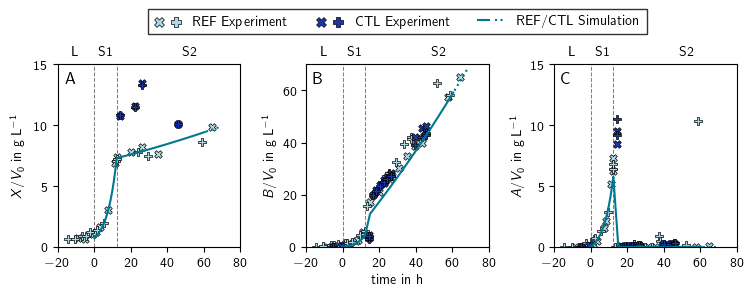

In [14]:
fig = plt.figure(dpi=100,figsize=(8,3))
axes = []
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,box_aspect=1)
    axes.append(ax)
    ax.set_xlim(-20,80)
    ax.set_xticks([-20,0,20,40,60,80])
    ax.axvline(0,color="grey",linestyle="--",zorder=-5,linewidth=.75)
    ax.axvline((tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"])/2,color="grey",linestyle="--",zorder=-5,linewidth=.75)

# PLOT SIMULATION
if True:
    dirnames = ["fb_ctl"] 
    colors = ["#007891"]
    labels = [r"Simulation"]
    
    for nr, (dirname,label) in enumerate(zip(dirnames,labels)):
        df = pd.read_csv("../simulations/"+dirname+"/df.csv")
        sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
        kwargs = {"color":colors[nr],"zorder":1}
        Gcon = (df.V.values-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000
        mask1 = Gcon <= 175.23
        mask2 = np.invert(mask1)
        p3_list = []
        for i, j in zip([mask1,mask2],["-",":"]):
            kwargs["linestyle"] = j
            axes[0].plot(df.t.values[i],df.X.values[i],**kwargs)
            axes[1].plot(df.t.values[i],df.P.values[i]*d4p3.metabolites.bt23dl_c.formula_weight/1000,**kwargs)
            p3, = axes[2].plot(df.t.values[i],df.S.values[i]*d4p3.metabolites.acoin_c.formula_weight/1000,label=label,**kwargs)
            p3_list.append(p3)
        
# Plot Experiment
if True:
    for run in ['paper_3C', 'paper_S3', 'control_A', 'control_B']:
        tmp = get_run(xls,run)
        kwargs = get_plot_kwargs(run)
        tcorr = tmp.t.values-tswitch_dict[run]+tnorm_dict[run]
        xcorr = tmp.X/tmp.V.values[0]*1000 # g/L (V0)
        gcorr = tmp.Gup/tmp.V.values[0]*1000 #/d4p3.metabolites.glc__D_e.formula_weight # mmol/L (V0)
        bcorr = tmp.B/tmp.V.values[0]*1000 #**2/d4p3.metabolites.bt23dl_c.formula_weight
        acorr = tmp.A/tmp.V.values[0]*1000 #**2/d4p3.metabolites.acoin_c.formula_weight
        axes[0].scatter(tcorr[np.isfinite(xcorr)],xcorr[np.isfinite(xcorr)],**kwargs)
        axes[1].scatter(tcorr,bcorr,**kwargs)
        axes[2].scatter(tcorr,acorr,**kwargs)
    p1 = axes[0].scatter(0,-100,color="lightblue",edgecolor="k",label="REF",marker="X",s=50,linewidth=.5)
    p2 = axes[0].scatter(0,-100,color="lightblue",edgecolor="k",label="REF",marker="P",s=50,linewidth=.5)
    p4 = axes[0].scatter(0,-100,color="#1737ab",edgecolor="k",label="CTL Experiment",marker="X",s=50,linewidth=.5)
    p5 = axes[0].scatter(0,-100,color="#1737ab",edgecolor="k",label="CTL Experiment",marker="P",s=50,linewidth=.5)
    
# Axes Labels
if True:
    axes[2].set_ylabel(r"$A/V_0$ in g\;L$^{-1}$")
    axes[0].set_ylabel(r"$X/V_0$ in g\;L$^{-1}$")
    # axes[3].set_ylabel(r"$G_{\rm con}/V_0$ in g\;L$^{-1}$")
    axes[1].set_ylabel(r"$B/V_0$ in g\;L$^{-1}$")
    axes[2].set_ylim(0,15)
    axes[0].set_ylim(0,15)
    axes[0].set_yticks([0,5,10,15])
    axes[2].set_yticks([0,5,10,15])
    # axes[0].set_ylim(0,250)
    axes[1].set_ylim(0,70)
    axes[0].set_title("\n")

    # Create invisible subplot.
    ax0 = fig.add_subplot(111, frame_on=False)
    ax0.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    ax0.grid(False)
    # Set the centered xlabel on invisible subplot.
    ax0.set_xlabel("time in h", labelpad=-15)
    
# Legend
if True:
    fig.align_ylabels()
    fig.tight_layout()
    ax1_pos = axes[0].get_position()
    ax2_pos = axes[2].get_position()
    legend_x = (ax1_pos.x0 + ax2_pos.x1) / 2
    fig.legend([(p1, p2),(p4,p5), tuple(p3_list)], ["REF Experiment",'CTL Experiment', 'REF/CTL Simulation'],handler_map={tuple: HandlerTuple(ndivide=None)},loc='center', bbox_to_anchor=(legend_x, .95), ncol=3)
    fig.tight_layout()
    
# Stage Labels
for ax in axes[:]:
    ymin, ymax = ax.get_ylim()
    dy = ymax-ymin
    ry = 1.05
    ay = ymin+dy*ry
    ax.text(-10,ay,r"L",ha="center")
    ax.text((tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"])/4,ay,r"S1",ha="center")
    ax.text((40-(tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"])/2)+(tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"]),ay,r"S2",ha="center")

# Panel Legends
if True:
    import matplotlib.transforms as mtransforms
    for name, ax in zip(['A','B','C','D','E','F'],axes):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

plt.show()

# FIGURE 6

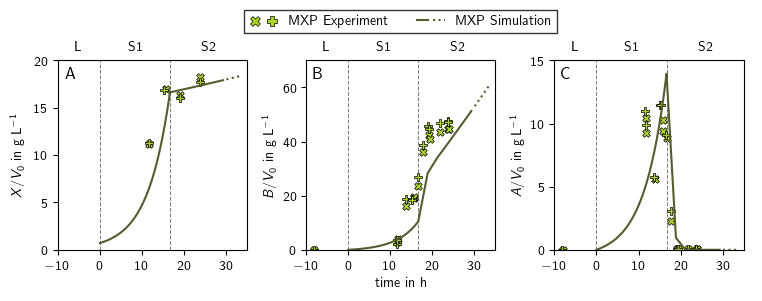

In [15]:
# CREATE FIGURE AND AXES
fig = plt.figure(dpi=100,figsize=(8,3))
axes = []
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,box_aspect=1)
    axes.append(ax)
    ax.set_xlim(-10,35)
    ax.set_xticks([-10,0,10,20,30])
    # STAGE BORDERS
    ax.axvline(0,color="grey",linestyle="--",zorder=-5,linewidth=.75)
    ax.axvline((tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/2,color="grey",linestyle="--",zorder=-5,linewidth=.75)

# PLOT SIMULATION
if True:
    dirnames = ["fb_mxp"] 
    colors = ["#565b30"]
    labels = [r"Simulation"]
    
    for nr, (dirname,label) in enumerate(zip(dirnames,labels)):
        df = pd.read_csv("../simulations/"+dirname+"/df.csv")
        sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
        kwargs = {"color":colors[nr],"zorder":1}
        Gcon = (df.V.values-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000
        mask1 = Gcon <= 175.23
        mask2 = np.invert(mask1)
        p3_list = []
        for i, j in zip([mask1,mask2],["-",":"]):
            kwargs["linestyle"] = j
            axes[0].plot(df.t.values[i],df.X.values[i],**kwargs)
            axes[1].plot(df.t.values[i],df.P.values[i]*d4p3.metabolites.bt23dl_c.formula_weight/1000,**kwargs)
            p3, = axes[2].plot(df.t.values[i],df.S.values[i]*d4p3.metabolites.acoin_c.formula_weight/1000,label=label,**kwargs)
            p3_list.append(p3)
        
        
# Plot Experiment
if True:
    for run in ["productivity_A","productivity_B"]:
        tmp = get_run(xls,run)
        kwargs = get_plot_kwargs(run)
        tcorr = tmp.t.values-tswitch_dict[run]+tnorm_dict[run]
        xcorr = tmp.X/tmp.V.values[0]*1000 # g/L (V0)
        gcorr = tmp.Gup/tmp.V.values[0]*1000 #/d4p3.metabolites.glc__D_e.formula_weight # mmol/L (V0)
        bcorr = tmp.B/tmp.V.values[0]*1000 #**2/d4p3.metabolites.bt23dl_c.formula_weight
        acorr = tmp.A/tmp.V.values[0]*1000 #**2/d4p3.metabolites.acoin_c.formula_weight
        axes[0].scatter(tcorr[np.isfinite(xcorr)],xcorr[np.isfinite(xcorr)],**kwargs)
        axes[1].scatter(tcorr,bcorr,**kwargs)
        axes[2].scatter(tcorr,acorr,**kwargs)
    p1 = axes[0].scatter(0,-100,color="#acd429",edgecolor="k",label="Experiment",marker="X",s=50,linewidths=.5)
    p2 = axes[0].scatter(0,-100,color="#acd429",edgecolor="k",label="Experiment",marker="P",s=50,linewidths=.5)
    
# Axes Labels
if True:
    axes[2].set_ylabel(r"$A/V_0$ in g\;L$^{-1}$")
    axes[0].set_ylabel(r"$X/V_0$ in g\;L$^{-1}$")
    axes[1].set_ylabel(r"$B/V_0$ in g\;L$^{-1}$")
    axes[2].set_ylim(0,15)
    axes[0].set_ylim(0,20)
    axes[2].set_yticks([0,5,10,15])
    axes[1].set_ylim(0,70)
    axes[0].set_title("\n")

    # Create invisible subplot.
    ax0 = fig.add_subplot(111, frame_on=False)
    ax0.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    ax0.grid(False)
    # Set the centered xlabel on invisible subplot.
    ax0.set_xlabel("time in h", labelpad=-10)
    
# Legend
if True:
    fig.align_ylabels()
    fig.tight_layout()
    ax1_pos = axes[0].get_position()
    ax2_pos = axes[2].get_position()
    legend_x = (ax1_pos.x0 + ax2_pos.x1) / 2
    fig.legend([(p1, p2), tuple(p3_list)], ['MXP Experiment', 'MXP Simulation'],handler_map={tuple: HandlerTuple(ndivide=None)},loc='center', bbox_to_anchor=(legend_x, .95), ncol=2)
    fig.tight_layout()
    
# Stage Labels
for ax in axes[:]:
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    dy = ymax-ymin
    ry = 1.05
    ay = ymin+dy*ry
    ax.text(xmin/2,ay,r"L",ha="center")
    ax.text((tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/4,ay,r"S1",ha="center")
    ax.text((xmax-(tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/2)/2+(tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/2,ay,r"S2",ha="center")

# Panel Legends
if True:
    import matplotlib.transforms as mtransforms
    for name, ax in zip(['A','B','C','D','E','F'],axes):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

plt.show()

# SUPPLEMENTARY FIGURE S3

paper_3C
paper_S3


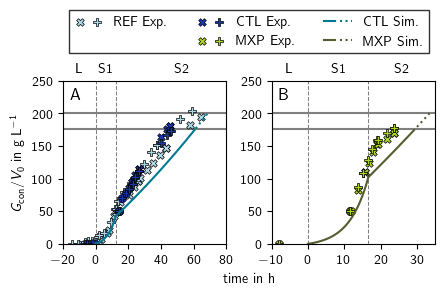

In [16]:
# CREATE FIGURE AND AXES
fig = plt.figure(dpi=100,figsize=(5,3))
axes = []
for i in range(2):
    ax = fig.add_subplot(1,2,i+1,box_aspect=1)
    axes.append(ax)
    ax.axhline(200, color="grey", zorder=-5)
    ax.axhline(175.23, color="grey", zorder=-5)

s = 30
# CTRL
if True:
    # PLOT SIMULATION
    if True:
        dirnames = ["fb_ctl"] 
        colors = ["#007891"]
        labels = [r"Simulation"]
        for nr, (dirname,label) in enumerate(zip(dirnames,labels)):
            df = pd.read_csv("../simulations/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
            kwargs = {"color":colors[nr],"zorder":1}
            Gcon = (df.V.values-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000
            mask1 = Gcon <= 175.23
            mask2 = np.invert(mask1)
            p3_list = []
            for i, j in zip([mask1,mask2],["-",":"]):
                kwargs["linestyle"] = j
                p3, = axes[0].plot(df.t.values[i],(df.V.values[i]-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000,**kwargs)
                p3_list.append(p3)
                
    # Plot Experiment
    if True:
        for run in ['paper_3C', 'paper_S3', 'control_A', 'control_B']:
            tmp = get_run(xls,run)
            kwargs = get_plot_kwargs(run)
            tcorr = tmp.t.values-tswitch_dict[run]+tnorm_dict[run]
            gcorr = tmp.Gup/tmp.V.values[0]*1000
            axes[0].scatter(tcorr,gcorr,**kwargs)

        p1 = axes[0].scatter(0,-100,color="lightblue",edgecolor="k",label="REF",marker="X",s=30,linewidth=.5)
        p2 = axes[0].scatter(0,-100,color="lightblue",edgecolor="k",label="REF",marker="P",s=30,linewidth=.5)
        p4 = axes[0].scatter(0,-100,color="#1737ab",edgecolor="k",label="CTL Experiment",marker="X",s=30,linewidth=.5)
        p5 = axes[0].scatter(0,-100,color="#1737ab",edgecolor="k",label="CTL Experiment",marker="P",s=30,linewidth=.5)

# PRODUCTIVITY   
if True:
    # PLOT SIMULATION
    if True:
        dirnames = ["fb_mxp"] 
        colors = ["#565b30"]
        labels = [r"Simulation"]

        for nr, (dirname,label) in enumerate(zip(dirnames,labels)):
            df = pd.read_csv("../simulations/"+dirname+"/df.csv")
            sum_dic, sum_df = parse_summary_file2("../simulations/"+dirname+"/summary.txt")
            kwargs = {"color":colors[nr],"zorder":1}
            Gcon = (df.V.values-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000
            mask1 = Gcon <= 175.23
            mask2 = np.invert(mask1)
            b3_list = []
            for i, j in zip([mask1,mask2],["-",":"]):
                kwargs["linestyle"] = j
                b3, = axes[1].plot(df.t.values[i],(df.V.values[i]-df.V.values[0])*c_G*d4p3.metabolites.glc__D_e.formula_weight/1000,**kwargs)
                b3_list.append(b3)
    # Plot Experiment
    if True:
        for run in ["productivity_A","productivity_B"]:
            tmp = get_run(xls,run)
            kwargs = get_plot_kwargs(run)
            tcorr = tmp.t.values-tswitch_dict[run]+tnorm_dict[run]
            gcorr = tmp.Gup/tmp.V.values[0]*1000 #/d4p3.metabolites.glc__D_e.formula_weight # mmol/L (V0)
            axes[1].scatter(tcorr,gcorr,**kwargs)
        b1 = axes[0].scatter(0,-100,color="#acd429",edgecolor="k",label="Experiment",marker="X",s=s,linewidths=.5)
        b2 = axes[0].scatter(0,-100,color="#acd429",edgecolor="k",label="Experiment",marker="P",s=s,linewidths=.5)
    
# Axes Labels
if True:
    axes[0].set_ylabel(r"$G_{\rm con}/V_0$ in g\;L$^{-1}$",labelpad=-5)
    axes[0].set_ylim(0,250)
    axes[1].set_ylim(0,250)
    axes[0].set_title("\n\n\n")

    # Create invisible subplot.
    ax0 = fig.add_subplot(111, frame_on=False)
    ax0.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    ax0.grid(False)
    # Set the centered xlabel on invisible subplot.
    ax0.set_xlabel("time in h", labelpad=0)
    p0, = plt.plot(0,0,color="w",label="~")
    
# Legend
if True:
    fig.align_ylabels()
    fig.tight_layout()
    ax1_pos = axes[0].get_position()
    ax2_pos = axes[1].get_position()
    legend_x = (ax1_pos.x0 + ax2_pos.x1) / 2
    fig.legend([(p1, p2),p0,(p4,p5), (b1, b2), tuple(p3_list), tuple(b3_list)], ["REF Exp."," ",'CTL Exp.', 'MXP Exp.', 'CTL Sim.', 'MXP Sim.'],handler_map={tuple: HandlerTuple(ndivide=None)},loc='center', bbox_to_anchor=(legend_x, .91), ncol=3)
    fig.tight_layout()
    
# Stage Labels
for ax in axes[:1]:
    ymin, ymax = ax.get_ylim()
    dy = ymax-ymin
    ry = 1.05
    ay = ymin+dy*ry
    ax.text(-10,ay,r"L",ha="center")
    ax.text((tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"])/4,ay,r"S1",ha="center")
    ax.text((40-(tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"])/2)+(tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"]),ay,r"S2",ha="center")
    ax.set_xlim(-20,80)
    ax.set_xticks([-20,0,20,40,60,80])
    # STAGE BORDERS
    ax.axvline(0,color="grey",linestyle="--",zorder=-5,linewidth=.75)
    ax.axvline((tnorm_dict["paper_3C"]+tnorm_dict["paper_S3"])/2,color="grey",linestyle="--",zorder=-5,linewidth=.75)
for ax in axes[1:]:
    ax.set_xlim(-10,35)
    ax.set_xticks([-10,0,10,20,30])
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    dy = ymax-ymin
    ry = 1.05
    ay = ymin+dy*ry
    ax.text(xmin/2,ay,r"L",ha="center")
    ax.text((tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/4,ay,r"S1",ha="center")
    ax.text((xmax-(tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/2)/2+(tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/2,ay,r"S2",ha="center")
    # STAGE BORDERS
    ax.axvline(0,color="grey",linestyle="--",zorder=-5,linewidth=.75)
    ax.axvline((tnorm_dict["productivity_A"]+tnorm_dict["productivity_B"])/2,color="grey",linestyle="--",zorder=-5,linewidth=.75)

# Panel Legends
if True:
    for name, ax in zip(['A','B','C','D','E','F'],axes):
        trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

plt.show()